## **Assunzioni della Regressione Lineare**

Le principali assunzioni della regressione lineare classica (OLS) indicano le condizioni ideali affinché i coefficienti stimati siano interpretabili e i test statistici sui coefficienti siano affidabili.

Nel nostro caso, per le analisi predittive è stato utilizzato un modello regolarizzato (Ridge), che garantisce stabilità e accuratezza anche in presenza di violazioni di alcune assunzioni. Tuttavia, per poter effettuare i test statistici classici (Shapiro-Wilk, Rainbow, Breusch-Godfrey, Breusch-Pagan), è necessario applicarli su un modello OLS costruito sulle stesse feature preprocessate utilizzate nella pipeline Ridge. In questo modo possiamo valutare la bontà della specificazione lineare e le proprietà dei residui

**5 assunzioni fondamentali**:

1. **Relazione lineare**  
   La relazione tra variabili indipendenti e variabile dipendente deve essere approssimativamente lineare.

2. **Normalità**  
   Gli errori (residui) devono essere distribuiti normalmente.

3. **Assenza di multicollinearità**  
   Le variabili indipendenti non devono essere fortemente correlate tra loro.

4. **Assenza di autocorrelazione**  
   I residui non devono essere correlati tra loro (soprattutto nei dati temporali).

5. **Omoscedasticità**  
   La varianza degli errori deve essere costante per tutti i valori delle variabili indipendenti.

## Requirements

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import pylab
from statsmodels.regression.linear_model import OLS

## Importazione del dataset pulito

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/cleaned_data.csv')

In [6]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,hour,day_of_week,month,year,is_weekend,lag_1,lag_24,lag_168,traffic_volume
0,none,6.20,0.0,0.0,90.0,clouds,overcast clouds,9.0,1.0,10.0,2012.0,False,5765.0,4832.0,5545.0,5599.0
1,none,8.22,0.0,0.0,90.0,clouds,overcast clouds,10.0,1.0,10.0,2012.0,False,5599.0,4395.0,4516.0,4534.0
2,none,9.96,0.0,0.0,90.0,clouds,overcast clouds,11.0,1.0,10.0,2012.0,False,4534.0,4411.0,4767.0,4691.0
3,none,10.93,0.0,0.0,75.0,clouds,broken clouds,12.0,1.0,10.0,2012.0,False,4691.0,4648.0,5026.0,5067.0
4,none,11.99,0.0,0.0,75.0,clouds,broken clouds,13.0,1.0,10.0,2012.0,False,5067.0,4602.0,4918.0,5030.0


## **Preprocessing**

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle


# Esempio: definisci le colonne numeriche reali
numeric_features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'lag_1', 'lag_24', 'lag_168']

categorical_features = ['hour', 'month', 'day_of_week', 'holiday', 'weather_main', 'weather_description', 'is_weekend']

# Encoder per le variabili categoriche
encoder = OneHotEncoder(
    handle_unknown='ignore', # ESSENZIALE per prevenire KeyError su dati di test/futuri
    sparse_output=False
)

# Scaler per le variabili numeriche
scaler = StandardScaler()


# --- 3. Creazione del Preprocessore (ColumnTransformer) ---
preprocessor = ColumnTransformer([
    # 'cat' applicherà l'encoder alle colonne categoriche
    ('cat', encoder, categorical_features),
    # 'num' applicherà lo scaler alle colonne numeriche
    ('num', scaler, numeric_features)
])

preprocessor = ColumnTransformer([
    ('cat', encoder, categorical_features),
    ('num', scaler, numeric_features)
])

#Dividi feature e label
X = data.drop('traffic_volume',axis=1)
Y = data['traffic_volume']
preprocessor.fit(X)
X = preprocessor.transform(X)


print("Preprocessing completato.")




Preprocessing completato.


## **Uso del Modello OLS per analisi statistiche**

Per l’analisi statistica e i test d’ipotesi sui coefficienti, utilizziamo un modello OLS senza penalizzazione. Questo perché la penalizzazione L2 di Ridge altera la distribuzione dei coefficienti, rendendo i test t e i p-value classici non validi.
Ridge, invece, viene utilizzato per la predizione, poiché la penalizzazione riduce la varianza del modello e migliora la capacità di generalizzazione su dati non osservati.

In [8]:
model = sm.OLS(Y,X).fit()

In [9]:
fittedvals = model.fittedvalues
residuals =model.resid

In [10]:
rsq = model.rsquared
adj_rsq = model.rsquared_adj
print('R Squared :',round(rsq,4))
print('Adjusted R Squared :',round(adj_rsq,4))

R Squared : 0.9611
Adjusted R Squared : 0.961


## **Validazione delle assunzioni**

### **1) Relazione Lineare**

È la relazione tra le variabili indipendenti e i residui, che deve essere lineare affinché la regressione lineare sia valida.

**Grafico di Valutazione**  
Il *Residual Plot* (grafico dei residui) viene utilizzato per valutare la linearità dei dati.

**Test di Linearità**  
*Rainbow Test*

- **Ipotesi Nulla (H0):** i dati sono lineari  
- **Ipotesi Alternativa (H1):** i dati non sono lineari  

**Decisione basata sul p-value**
- p-value > 0.05 → Accetto l'ipotesi nulla (i dati sono lineari)  
- p-value < 0.05 → Rifiuto l'ipotesi nulla (i dati non sono lineari)


In [60]:
from statsmodels.stats.api import linear_rainbow,het_goldfeldquandt
stat = linear_rainbow(model)
stat
if stat[1] > 0.05:
    print('The p value is',round(stat[1],4),' > 0.05. So Not Rejecting the Null')
else:
    print('The p value is',round(stat[1],4),' < 0.05. So Rejecting the Null')

The p value is 0.0  < 0.05. So Rejecting the Null


Dal p-value possiamo affermare che i dati NON sono lineari.

### **2) Normalità**

I residui dovrebbero seguire una distribuzione normale.

**Grafico di Valutazione**  
Q-Q Plot — verifica della normalità

In [21]:
st_residual = model.get_influence().resid_studentized_internal

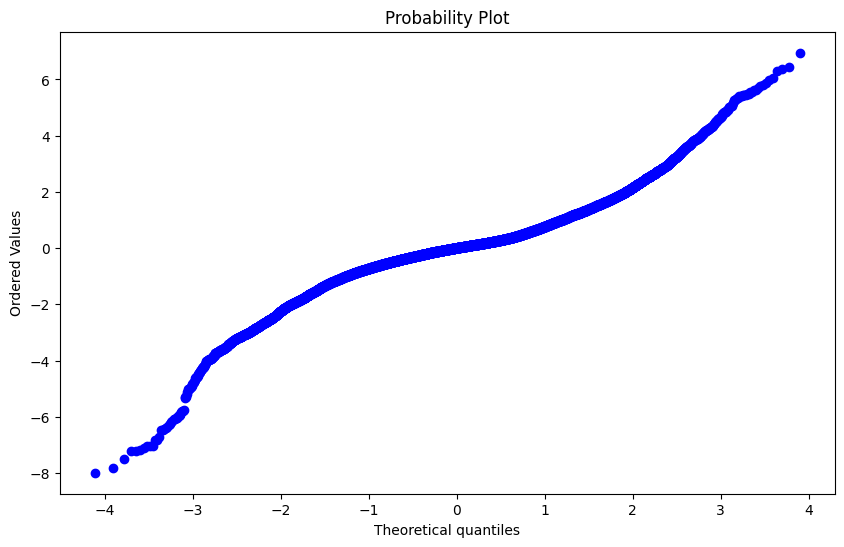

In [22]:
plt.figure(figsize=(10,6))
stats.probplot(st_residual,dist='norm',plot=pylab)
plt.show()

**Test di Normalità**  
Shapiro Test

- **Ipotesi Nulla (H0):** i dati seguono una distribuzione gaussiana  
- **Ipotesi Alternativa (H1):** i dati non seguono una distribuzione gaussiana

In [59]:
from scipy.stats import shapiro
import numpy as np
sample = np.random.choice(st_residual, size=5000, replace=False)
stat = shapiro(sample)

if stat[1] < 0.05:
    print('The p value is',round(stat[1],4),' < 0.05. So Rejecting the Null')
else:
    print('The p value is',round(stat[1],4),' > 0.05. So Not Rejecting the Null')

The p value is 0.0  < 0.05. So Rejecting the Null


Da entrambi i test si evince la non-Normalità dei dati

### **3) Multicollinearità**

Non deve esserci multicollinearità nei dati. La multicollinearità si verifica quando le variabili indipendenti sono troppo fortemente correlate tra loro.

**Test di Multicollinearità**  
Variance Inflation Factor (VIF)

- **VIF = 1** → Nessuna correlazione  
- **VIF < 5** → Moderata  
- **VIF > 5 e < 10** → Elevata  
- **VIF > 10** → Molto elevata — la variabile dovrebbe essere rimossa


In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
# NOTA: Rimosso 'from statsmodels.stats.outliers_detection import variance_inflation_factor'

# ==============================================================================
# FUNZIONE MANUALE PER IL CALCOLO VIF (VIF = 1 / (1 - R^2))
# ==============================================================================

def calculate_vif_manual(X, feature_names):
    """Calcola il VIF per ogni colonna nella matrice di feature X (ndarray)."""

    # 1. Crea un DataFrame temporaneo per gestire i nomi delle colonne
    X_df = pd.DataFrame(X, columns=feature_names)
    vif_data = {'Feature Name': [], 'VIF': []}

    # 2. Iterazione su ogni colonna (feature)
    for i in range(X_df.shape[1]):
        # y_vif è la colonna corrente (che vogliamo predire)
        feature_name = X_df.columns[i]
        y_vif = X_df.iloc[:, i]

        # X_vif è tutte le altre colonne
        X_vif = X_df.drop(feature_name, axis=1)

        # Aggiungi la costante per il calcolo R^2
        X_vif = sm.add_constant(X_vif, prepend=False)

        # 3. Fitta il modello OLS (Regressione Lineare di Xi sugli altri X)
        model_fit = sm.OLS(y_vif, X_vif).fit()

        # 4. Calcola VIF
        r_squared = model_fit.rsquared
        if r_squared >= 1.0:
             vif = np.inf
        else:
             vif = 1 / (1 - r_squared)

        vif_data['Feature Name'].append(feature_name)
        vif_data['VIF'].append(vif)

    return pd.DataFrame(vif_data)

# ==============================================================================
# ESECUZIONE
# ==============================================================================

print("--- VIF (Variance Inflation Factor) Calcolato Manualmente ---")

"""
# Chiama la funzione con la matrice X preprocessata
feature_names_out = preprocessor.get_feature_names_out()

# 3. Pulizia e Preparazione della lista finale
# Spesso i nomi di output hanno un prefisso come 'cat__' o 'num__' che vogliamo rimuovere.
feature_names = [name.split('__')[-1] for name in feature_names_out]

vif_results_df = calculate_vif_manual(X, feature_names)

# Stampa i risultati ordinati per VIF decrescente
print(vif_results_df.sort_values(by='VIF', ascending=False).to_string(index=False))
"""

numeric_only = [
    'lag_1', 'lag_24', 'lag_168',
    'temp', 'clouds_all', 'rain_1h', 'snow_1h'
]

X_num = data[numeric_only].values
vif_results_df = calculate_vif_manual(X_num, numeric_only)

print(vif_results_df.sort_values(by='VIF', ascending=False))


--- VIF (Variance Inflation Factor) Calcolato Manualmente ---
  Feature Name       VIF
2      lag_168  5.788052
0        lag_1  4.390249
1       lag_24  3.758358
3         temp  1.045754
4   clouds_all  1.029507
5      rain_1h  1.009991
6      snow_1h  1.000596


L’analisi del VIF evidenzia la presenza di una moderata multicollinearità tra alcune variabili indipendenti, in particolare tra i termini di ritardo temporale. Sebbene un predittore presenti un VIF leggermente superiore alla soglia convenzionale di 5, il fenomeno risulta contenuto e non critico. L’adozione della regressione Ridge consente di mitigare gli effetti della multicollinearità, garantendo la stabilità delle stime e una migliore capacità di generalizzazione del modello.


### **4) Autocorrelazione**

Il Breusch-Godfrey test è un test statistico utilizzato per rilevare la presenza di autocorrelazione seriale dei residui in un modello di regressione lineare, soprattutto quando i dati sono temporali. L’autocorrelazione indica che gli errori del modello non sono indipendenti tra loro, violando una delle assunzioni fondamentali della regressione OLS.

Ipotesi nulla (H₀): non esiste autocorrelazione nei residui

Ipotesi alternativa (H₁): esiste autocorrelazione seriale

Un p-value basso (tipicamente < 0.05) porta a rifiutare H₀, indicando che i residui sono correlati. La presenza di autocorrelazione non impedisce di fare predizione con modelli regolarizzati o basati su alberi, ma rende non affidabili gli errori standard e i test sui coefficienti se si usasse un OLS puro.

In [65]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
# model_ols = sm.OLS(y, X).fit()

bg_test = acorr_breusch_godfrey(model, nlags=24)
lm_stat, lm_pvalue, f_stat, f_pvalue = bg_test

print("Breusch-Godfrey test")
print(f"LM statistic: {lm_stat:.4f}")
print(f"LM p-value: {lm_pvalue:.4f}")
print(f"F statistic: {f_stat:.4f}")
print(f"F p-value: {f_pvalue:.4f}")

alpha = 0.05

if lm_pvalue < alpha:
    print("Rifiuto H0 → autocorrelazione presente")
else:
    print("Non rifiuto H0 → nessuna autocorrelazione significativa")


Breusch-Godfrey test
LM statistic: 9612.7644
LM p-value: 0.0000
F statistic: 552.0000
F p-value: 0.0000
Rifiuto H0 → autocorrelazione presente


Nel nostro dataset, il test Breusch-Godfrey ha evidenziato autocorrelazione dei residui. Questo era prevedibile vista la natura temporale della serie e l’uso di variabili lag. L’adozione di Ridge e di cross-validation temporale garantisce comunque stime stabili e predizioni affidabili, pur riconoscendo le limitazioni per l’inferenza statistica classica.

### **5) Omoscedasticità**

I residui dovrebbero avere varianza costante lungo tutta la retta di regressione.

**Grafico di Valutazione**  
Scale-Location Plot — utilizzato per valutare l'omoscedasticità

**Test di Omoschedasticità**  
Goldfeld-Quandt Test

- **Ipotesi Nulla (H0):** i dati sono omoscedastici (varianza uniforme)  
- **Ipotesi Alternativa (H1):** i dati sono eteroscedastici (varianza non uniforme)


In [63]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

f_stat, p_value, _ = het_goldfeldquandt(Y, model.model.exog)

alpha = 0.05

print(f"Goldfeld-Quandt F statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print("Rifiuto H0 → eteroschedasticità presente")
else:
    print("Non rifiuto H0 → residui omoschedastici")


Goldfeld-Quandt F statistic: 0.9152
p-value: 1.0000
Non rifiuto H0 → residui omoschedastici


In questo caso l'ipotesi nulla è rigettata, cioè i dati sono Omoschedastici

# Diagnosi finale sul modello e sui residui

Abbiamo eseguito una valutazione completa delle assunzioni della regressione lineare classica (OLS) tramite test statistici sui residui:

- Normalità (Shapiro-Wilk): i residui non seguono una distribuzione normale.

- Linearità (Rainbow): alcune relazioni tra predittori e target mostrano deviazioni dalla linearità.

- Autocorrelazione (Breusch-Godfrey): presente, coerente con la natura temporale della serie.

- Omoschedasticità: i residui risultano omoschedastici, con varianza costante.

- Multicollinearità (VIF): valori accettabili per le variabili numeriche principali, alcune correlazioni tra dummy categoriche inevitabili.

Interpretazione e scelta metodologica:
Nonostante la non-normalità e le leggere deviazioni dalla linearità, l’obiettivo principale è la predizione accurata. Pertanto:

Non sono state applicate trasformazioni alle variabili.

Si è scelto di utilizzare modelli regolarizzati (Ridge) e basati su alberi (Random Forest, Gradient Boosting), che gestiscono efficacemente residui non normali, autocorrelazione e relazioni non lineari.

I test sulle assunzioni servono principalmente a documentare le limitazioni dell’inferenza statistica sui coefficienti OLS, giustificando la scelta di modelli predittivi robusti.

Conclusione: i modelli adottati garantiscono stabilità, accuratezza predittiva e gestione della multicollinearità, pur riconoscendo che alcune assunzioni classiche della regressione lineare (normalità e linearità) non sono completamente rispettate.